In [118]:
import json
import urllib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

In [193]:
'''
Restrictions:
A prediction cannot be run for a time that is in the past
A prediction cannot be run for a time that is more than 180 hours in the future
'''


def get_url_datetime_str(datetime):
    year = datetime.year
    month = datetime.month
    day = datetime.day
    hour = datetime.hour
    minute = datetime.minute
    second = datetime.second
    
    month = str(month) if month >= 10 else '0'+str(month)
    day = str(day) if day >= 10 else '0'+str(day)
    hour = str(hour) if hour >= 10 else '0'+str(hour)
    minute = str(minute) if minute >= 10 else '0'+str(minute)
    second = str(second) if second >= 10 else '0'+str(second)
    
    # URL encoding RFC 3986
    output = '{0}-{1}-{2}T{3}:{4}:{5}+00:00'.format(year,month,day,hour,minute,second)
    return(output)


def get_hab_path(latitude,longitude,datetime):
    base_url = 'http://predict.cusf.co.uk/api/v1/'

    datetime_str = get_url_datetime_str(datetime)
    ascent_rate = 5
    burst_altitude = 30000
    descent_rate = 5

    url_params = {'launch_latitude': latitude,
                  'launch_longitude': longitude,
                  'launch_datetime': datetime_str,
                  'ascent_rate': ascent_rate,
                  'burst_altitude': burst_altitude,
                  'descent_rate': descent_rate
                 }


    encoded_params = urllib.parse.urlencode(url_params)

    request_url = base_url + '?' + encoded_params

    response = urllib.request.urlopen(request_url)
    data = json.load(response)

    return data

def get_trajectories(latitude,longitude, minutes_timedelta=60, total_minutes=24*60):
    
    if (total_minutes > 180 * 60):
        print('Server does not accept predictions of more than 180h in advance. Using 180h instead.')
        total_minutes = 180 * 60
    current_datetime = datetime.datetime.now()
    trajectories = []
    datetimes = []
    
    minute_offset = 0
    while (minute_offset < total_minutes):
        timedelta = datetime.timedelta(minutes=minutes_timedelta)
        current_datetime = current_datetime + timedelta

        data = get_hab_path(latitude,longitude,current_datetime)
        prediction_list = data['prediction']

        path = []
        burst_index = 0
        for stage in prediction_list:
            trajectory = stage['trajectory']
            for i, point in enumerate(trajectory):
                path.append([point['latitude'], point['longitude'], point['altitude']])
            burst_index = i
        path = np.array(path).T
        
        trajectories.append(path)
        datetimes.append(point['datetime'])
        
        minute_offset = minute_offset + minutes_timedelta
    
    return trajectories, datetimes

In [194]:
latitude = 52.48477398
longitude = 13.3481206
trajectories, datetimes = get_trajectories(latitude, longitude)

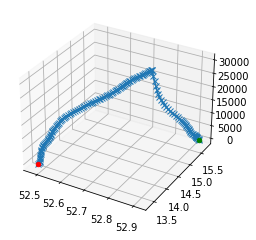

In [190]:
path = trajectories[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot(path[0], path[1], path[2], marker = 'x')
ax.scatter(*path.T[0], color = 'red')
ax.scatter(*path.T[-1], color = 'green')
plt.show()

In [191]:
features = [path.T for path in trajectories]

fig = go.Figure()
for i, feat in enumerate(features):
    
    fig.add_trace(
        go.Scatter3d(
            x=feat[:,0],
            y=feat[:,1],
            z=feat[:,2],
            marker=dict(
                size=4,
                color=path[2],
                colorscale='Viridis',
            ),
            line=dict(
                color='darkblue',
                width=2
            )
        )
    )

fig.update_layout(
    width=800,
    height=700,
    autosize=True,
    scene=dict(
        camera=dict(
            up=dict(x=0,y=0,z=1),
            eye=dict(x=0,y=1.0707,z=1)),
        aspectratio = dict(x=1,y=1,z=0.7),
        aspectmode = 'manual'
    ),
)

fig.show()